In [1]:
import torch

torch.set_default_dtype(torch.float32)
torch.manual_seed(91021)
torch.__version__

'2.2.1+cu121'

# 1. Make classification data


In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=91021)

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.2483671  -0.81447779]
 [-0.82877672 -0.18907591]
 [ 0.15490295 -0.77510797]
 [-0.87037195  0.53598668]
 [-0.86404739 -0.00505865]]

First 5 y labels:
[1 1 1 0 1]


In [4]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.248367,-0.814478,1
1,-0.828777,-0.189076,1
2,0.154903,-0.775108,1
3,-0.870372,0.535987,0
4,-0.864047,-0.005059,1
5,0.970214,-0.071646,0
6,0.306635,0.938536,0
7,-0.486692,0.660680,1
8,-0.446776,0.635964,1
9,-0.576145,-0.555555,1


In [5]:
# check different labels count
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

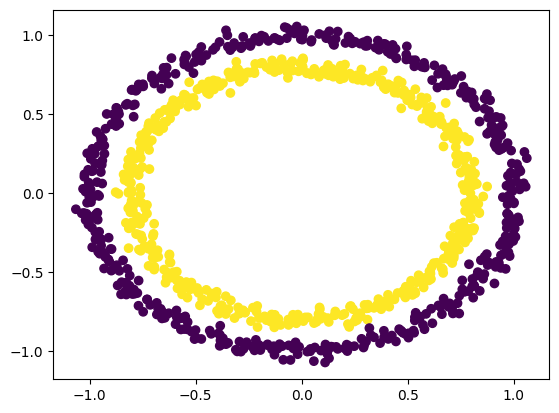

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

## 1.1 input and output shapes


In [7]:
# check the shapes of inputs and labels
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [ 0.2483671  -0.81447779] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 turn data into tensors and create splits


In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.2484, -0.8145],
         [-0.8288, -0.1891],
         [ 0.1549, -0.7751],
         [-0.8704,  0.5360],
         [-0.8640, -0.0051]]),
 tensor([1., 1., 1., 0., 1.]))

In [10]:
# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91021)

# 2. Building the model


In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # takes in 2 features (X) and produces 5 features
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        # takes in 5 features (hidden units) and produces 1 feature (y)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [13]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# make some predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0719],
        [ 0.7431],
        [-0.0718],
        [ 0.5848],
        [ 0.3984],
        [-0.0535],
        [ 0.2071],
        [ 0.1292],
        [ 0.5821],
        [ 0.2687]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])


In [15]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# create optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
    # compare two tensors
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# 3. Trainmodel


## 3.1 how it works


In [17]:
# view of the first 10 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0719],
        [ 0.7431],
        [-0.0718],
        [ 0.5848],
        [ 0.3984]], grad_fn=<SliceBackward0>)

In [18]:
# use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5180],
        [0.6777],
        [0.4820],
        [0.6422],
        [0.5983]], grad_fn=<SigmoidBackward0>)

In [19]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 1., 1.], grad_fn=<SqueezeBackward0>)

## 3.2 building a training and testing loop


In [20]:
torch.manual_seed(91021)

# set number of epochs
epochs = 100

# allocate data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    ### training
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # 3. zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. step
    optimizer.step()

    ### testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happening
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.71996, Acc: 58.88% | Test Loss: 0.71418, Test Acc: 55.00%
Epoch: 10 | Loss: 0.70350, Acc: 52.00% | Test Loss: 0.70008, Test Acc: 53.00%
Epoch: 20 | Loss: 0.69872, Acc: 50.38% | Test Loss: 0.69608, Test Acc: 52.50%
Epoch: 30 | Loss: 0.69701, Acc: 49.88% | Test Loss: 0.69480, Test Acc: 52.00%
Epoch: 40 | Loss: 0.69618, Acc: 49.88% | Test Loss: 0.69431, Test Acc: 50.50%
Epoch: 50 | Loss: 0.69565, Acc: 49.62% | Test Loss: 0.69410, Test Acc: 49.50%
Epoch: 60 | Loss: 0.69525, Acc: 49.38% | Test Loss: 0.69399, Test Acc: 49.50%
Epoch: 70 | Loss: 0.69492, Acc: 49.38% | Test Loss: 0.69394, Test Acc: 49.50%
Epoch: 80 | Loss: 0.69464, Acc: 50.00% | Test Loss: 0.69392, Test Acc: 49.00%
Epoch: 90 | Loss: 0.69441, Acc: 49.75% | Test Loss: 0.69392, Test Acc: 50.00%


# 4. Make predictions


In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


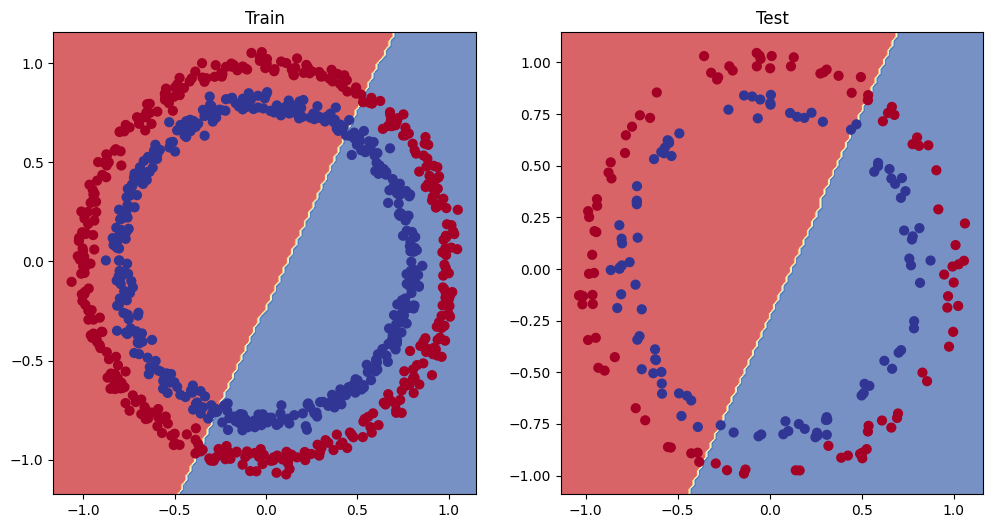

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. attempt improving


In [23]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(91021)
epochs = 1000
for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.70811, Acc: 49.88% | Test Loss: 0.70328, Test Acc: 50.50%
Epoch: 100 | Loss: 0.69291, Acc: 50.75% | Test Loss: 0.69456, Test Acc: 49.50%
Epoch: 200 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69511, Test Acc: 46.50%
Epoch: 300 | Loss: 0.69288, Acc: 51.50% | Test Loss: 0.69521, Test Acc: 46.00%
Epoch: 400 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69524, Test Acc: 46.00%
Epoch: 500 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69525, Test Acc: 46.50%
Epoch: 600 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69526, Test Acc: 46.50%
Epoch: 700 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69526, Test Acc: 46.50%
Epoch: 800 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69526, Test Acc: 46.50%
Epoch: 900 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69526, Test Acc: 46.50%


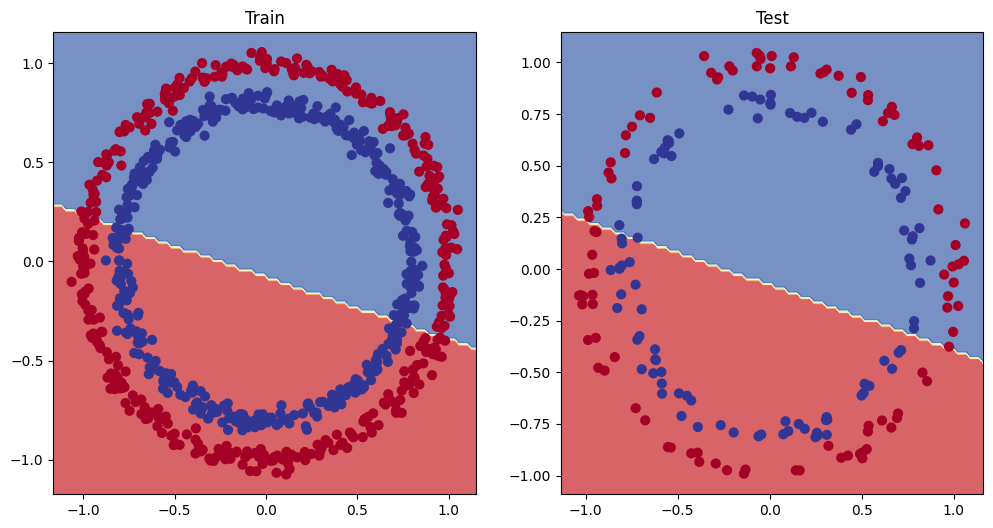

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# 6. Non linearity


## 6.1 recreating non-linear data


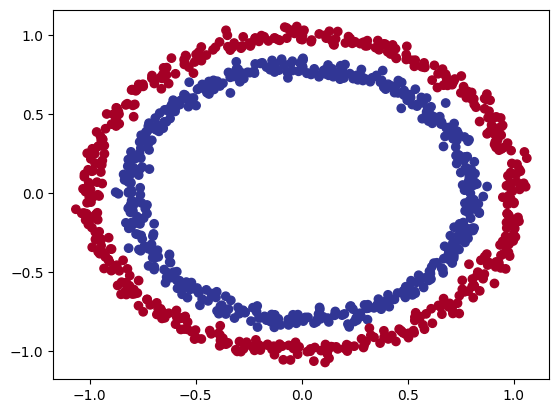

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=91021)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [28]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91021)

## 6.2 Non linear model


In [29]:
from torch import nn


class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        z = self.layer_1(x)
        z = self.relu(z)
        z = self.layer_2(z)
        z = self.relu(z)
        z = self.layer_3(z)
        return z


model_3 = CircleModelV2().to(device)
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3109, -0.1595],
                      [ 0.6618, -0.4948],
                      [ 0.0105,  0.1744],
                      [-0.0101,  0.5090],
                      [-0.6543, -0.4912],
                      [ 0.5658,  0.6920],
                      [ 0.0815, -0.3606],
                      [-0.6156, -0.2883],
                      [ 0.4497, -0.0687],
                      [-0.6705, -0.2056]])),
             ('layer_1.bias',
              tensor([ 0.0672,  0.0278,  0.3636, -0.4848,  0.6537,  0.5150, -0.2843, -0.4440,
                      -0.1289,  0.0502])),
             ('layer_2.weight',
              tensor([[ 0.1499,  0.0756, -0.0317, -0.1697,  0.2460,  0.1333, -0.1759,  0.0928,
                        0.1993,  0.1965],
                      [-0.0024,  0.2010, -0.1766, -0.0688, -0.2927,  0.1751,  0.2922, -0.1745,
                        0.0770, -0.0429],
                      [ 0.0271,  0.1858, -0.2624, -0.0317, -0.1480, -0.0

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [31]:
y_train[:10]

tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0.])

In [32]:
torch.manual_seed(91021)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    # forward pass
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    # loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.70092, Acc: 49.88% | Test Loss: 0.70025, Test Acc: 50.50%
Epoch: 100 | Loss: 0.69217, Acc: 50.88% | Test Loss: 0.69353, Test Acc: 45.00%
Epoch: 200 | Loss: 0.68945, Acc: 54.12% | Test Loss: 0.69161, Test Acc: 49.00%
Epoch: 300 | Loss: 0.68610, Acc: 56.38% | Test Loss: 0.68886, Test Acc: 53.50%
Epoch: 400 | Loss: 0.68224, Acc: 55.50% | Test Loss: 0.68551, Test Acc: 52.00%
Epoch: 500 | Loss: 0.67678, Acc: 56.38% | Test Loss: 0.68050, Test Acc: 56.50%
Epoch: 600 | Loss: 0.66885, Acc: 61.00% | Test Loss: 0.67286, Test Acc: 58.00%
Epoch: 700 | Loss: 0.65679, Acc: 64.38% | Test Loss: 0.66098, Test Acc: 60.00%
Epoch: 800 | Loss: 0.63670, Acc: 68.88% | Test Loss: 0.64050, Test Acc: 67.50%
Epoch: 900 | Loss: 0.59855, Acc: 83.25% | Test Loss: 0.60005, Test Acc: 84.50%


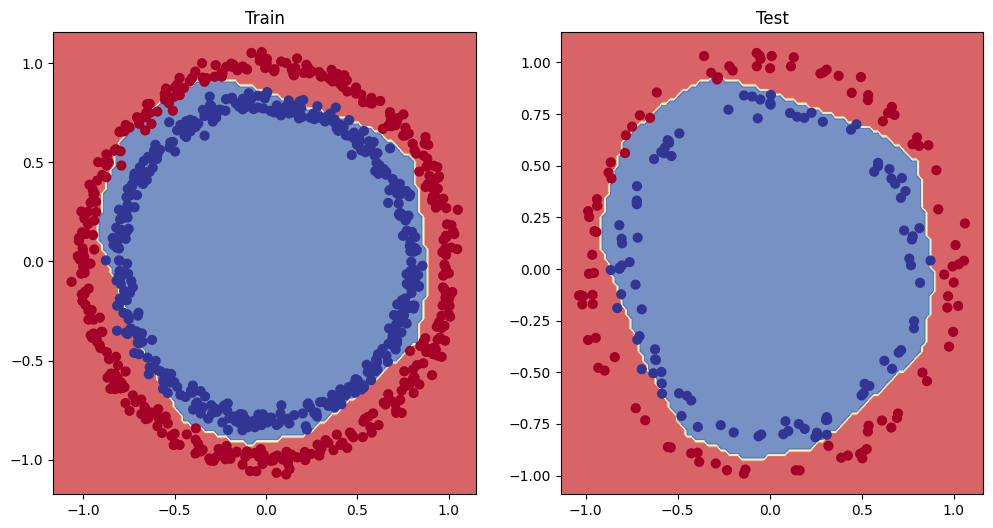

In [33]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# Multi-class classification


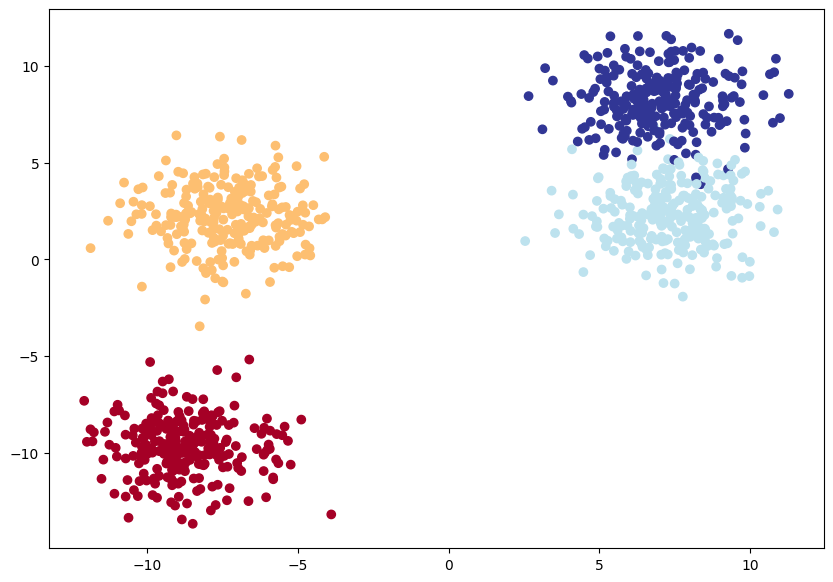

In [43]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 91021

X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED,
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [45]:
from torch import nn


class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [47]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [48]:
# fit the model
torch.manual_seed(91021)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    # forward pass
    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_preds)
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backwards
    loss.backward()
    # step
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Test loss: 1.15017, Test acc: 48.00%
Test loss: 1.02256, Test acc: 48.00%
Test loss: 0.92496, Test acc: 48.00%
Test loss: 0.84087, Test acc: 53.50%
Test loss: 0.77020, Test acc: 60.00%
Test loss: 0.71280, Test acc: 68.50%
Test loss: 0.66670, Test acc: 69.00%
Test loss: 0.62904, Test acc: 69.50%
Test loss: 0.59754, Test acc: 70.00%
Test loss: 0.57081, Test acc: 70.50%
Test loss: 0.54777, Test acc: 70.50%
Test loss: 0.52770, Test acc: 70.50%
Test loss: 0.51001, Test acc: 71.00%
Test loss: 0.49448, Test acc: 72.00%
Test loss: 0.48062, Test acc: 72.50%
Test loss: 0.46830, Test acc: 72.50%
Test loss: 0.45732, Test acc: 72.50%
Test loss: 0.44737, Test acc: 72.50%
Test loss: 0.43834, Test acc: 72.50%
Test loss: 0.43014, Test acc: 72.50%
Test loss: 0.42261, Test acc: 72.50%
Test loss: 0.41568, Test acc: 72.50%
Test loss: 0.40925, Test acc: 72.50%
Test loss: 0.40325, Test acc: 72.50%
Test loss: 0.39758, Test acc: 73.00%
Test loss: 0.39224, Test acc: 73.00%
Test loss: 0.38718, Test acc: 73.00%
T

In [49]:
# make preds

model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_logits[:10], y_preds[:10]

(tensor([[ 8.2827e+00,  4.9295e+00, -1.0394e+01, -1.1040e+01],
         [ 7.8598e+00,  4.8216e+00, -1.0000e+01, -1.0539e+01],
         [ 3.8745e-01,  1.8255e+00, -1.7386e+00, -1.1887e+00],
         [-5.7777e+00, -3.1778e+00, -3.1490e+00,  6.3831e+00],
         [-5.1254e+00, -2.9414e+00,  6.1770e+00,  1.7754e+00],
         [ 7.5186e+00,  4.6135e+00, -9.5375e+00, -1.0080e+01],
         [-4.4851e+00, -2.3986e+00,  5.8336e+00,  1.2629e+00],
         [ 4.3065e+00,  3.2111e+00, -5.8487e+00, -6.0077e+00],
         [-2.5063e+00, -6.7545e-01,  4.1363e+00, -3.0786e-03],
         [ 1.1982e+00,  2.2242e+00, -2.7234e+00, -2.2371e+00]]),
 tensor([0, 0, 1, 3, 2, 0, 2, 0, 2, 1]))

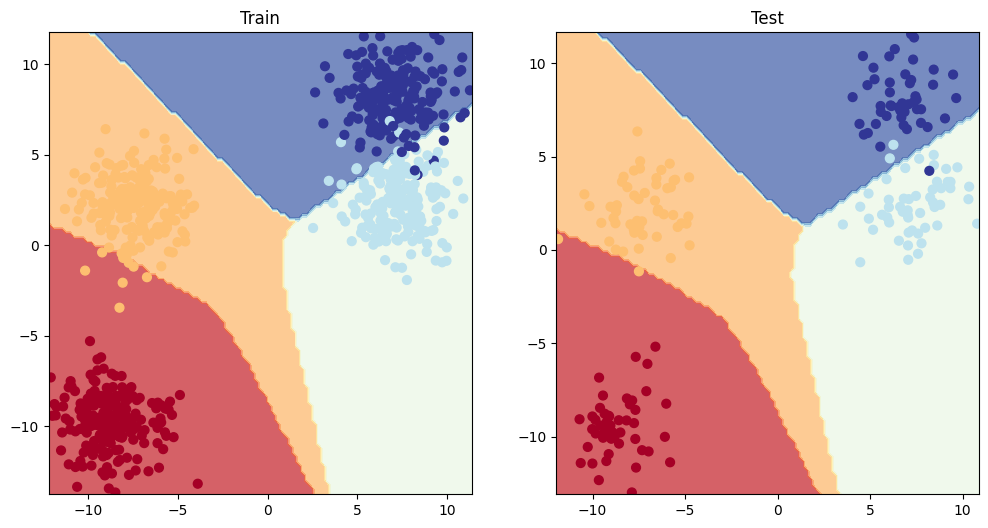

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)